# Import and misc

In [1]:
# !pip install torchaudio==0.9.1
# !pip install thop

In [2]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import os
import random
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

# фиксируем сиды
SEED = 3407
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)

# change to 'qnnpack' if have ARM architecture
torch.backends.quantized.engine = 'fbgemm'
qconfig = torch.quantization.get_default_qconfig('fbgemm')

MAX_QUALITY = 1.1 * 5e-5

# 0. Base structure and utils

##  0.1 Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [3]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device('cpu')

CONFIG = TaskConfig()

## 0.2 Data

In [4]:
# !wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
# !mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

In [5]:
class SpeechCommandDataset(Dataset):
    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)


In [6]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

dataset.csv.sample(5)

,path,keyword,label
4125,speech_commands/dog/d107dc42_nohash_0.wav,dog,0
28633,speech_commands/seven/e57d35bc_nohash_0.wav,seven,0
17508,speech_commands/marvin/f21893dc_nohash_1.wav,marvin,0
32604,speech_commands/nine/90b0b91a_nohash_0.wav,nine,0
48678,speech_commands/bird/2d3c8dcb_nohash_2.wav,bird,0


## 0.3 Augmentations

In [7]:
class AugsCreation:
    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)


In [8]:
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [9]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

## 0.4 Sampler for oversampling:

In [10]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler


In [11]:
train_sampler = get_sampler(train_set.csv['label'].values)
val_sampler = get_sampler(val_set.csv['label'].values)

In [12]:
class Collator:
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels


## 0.5  Dataloaders

In [13]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=4, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=4, pin_memory=True)

## 0.6 Creating MelSpecs on GPU for speeeed: 

In [14]:
class LogMelspec:
    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [15]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

## 0.7 Quality measurment functions:

In [16]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [17]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

## 0.8 Baseline model

In [18]:
class Attention(nn.Module):
    def __init__(self, hidden_size: int):
        super().__init__()
        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):
    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output


In [19]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [20]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [21]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

## 0.9 Training

In [22]:
base_model = CRNN(CONFIG).to(CONFIG.device)

opt = torch.optim.Adam(
    base_model.parameters(),
    lr=CONFIG.learning_rate,
    weight_decay=CONFIG.weight_decay
)

base_model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

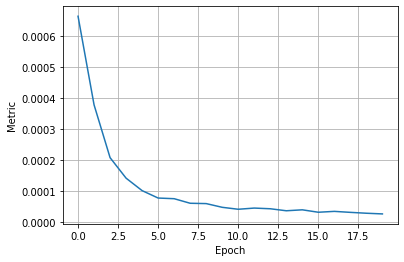

END OF EPOCH 19: au_fa_fr = 2.5236758720563763e-05


In [23]:
# TRAIN

# чтобы не переучивать, если уже посчитали
if "base_model.pth" in os.listdir():
    base_model.load_state_dict(torch.load("base_model.pth"))
    au_fa_fr = validation(base_model, val_loader, melspec_val, CONFIG.device)
    print(f'LOADED MODEL: au_fa_fr = {au_fa_fr}')

else:
    history = defaultdict(list)

    for n in range(CONFIG.num_epochs):

        train_epoch(
            base_model, opt, train_loader,
            melspec_train, CONFIG.device
        )

        au_fa_fr = validation(
            base_model, val_loader,
            melspec_val, CONFIG.device
        )

        history['val_metric'].append(au_fa_fr)

        clear_output()
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.grid()
        plt.show()

        print(f'END OF EPOCH {n}: au_fa_fr = {au_fa_fr}')

    # сохраним веса, чтобы не переучивать
    torch.save(base_model.state_dict(), "base_model.pth")

# last metric value as basline quality
BASELINE_QUALITY = au_fa_fr

In [24]:
import string
from thop import profile

def get_model_size_in_megabytes(model):
    num_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
    param_size = next(model.parameters()).element_size()
    return (num_params * param_size) / (2 ** 20)

def get_file_size_in_megabytes(model):
    rand_str = ''.join(random.choices(string.ascii_lowercase + string.digits, k=10))
    tmp_path = f"./{rand_str}.pth"
    torch.save(model, tmp_path)
    file_size = os.path.getsize(tmp_path) / (2 ** 20)
    os.remove(tmp_path)
    return file_size

def get_perfomance(model, batch):
    return profile(model, (batch, ))

# 1. Target compression/speedup metrics

In [25]:
@torch.no_grad()
def get_model_target_stats(model, prefix, is_initial=False):
    stats = {}
    stats[f"{prefix}_model_size"] = get_model_size_in_megabytes(model)
    stats[f"{prefix}_file_size"] = get_file_size_in_megabytes(model)
    
    model.eval()
    dummy_batch = next(iter(val_loader))[0].to(CONFIG.device)
    dummy_batch = melspec_val(dummy_batch)

    stats[f"{prefix}_macs"], _ = get_perfomance(model, dummy_batch)

    if not is_initial:
        stats[f"{prefix}_model_size_compression_rate"] = BASELINES["base_model_size"] / stats[f"{prefix}_model_size"]
        stats[f"{prefix}_file_size_compression_rate"] = BASELINES["base_file_size"] / stats[f"{prefix}_file_size"]
        stats[f"{prefix}_macs_speedup_rate"] = BASELINES["base_macs"] / stats[f"{prefix}_macs"]

    return stats


In [26]:
BASELINES = get_model_target_stats(base_model, prefix="base", is_initial=True)
for key, value in BASELINES.items():
    print(f"{key}: {value}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
base_model_size: 0.2687187194824219
base_file_size: 0.27574634552001953
base_macs: 119527424.0


# 2. Streaming

In [27]:
class StreamingCRNN(nn.Module):
    def __init__(self, config: TaskConfig, frame_window_length: int, gru_window_length: int):
        super().__init__()
        self.config = config
        self.kernel_size = config.kernel_size
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)

        self.frame_window_length = frame_window_length
        self.gru_window_length = gru_window_length
        self.register_buffer("frames_buffer", torch.Tensor([]))
        self.register_buffer("hiddens_buffer", torch.Tensor([]))
        self.register_buffer("last_hidden", None)
        self.streaming = False

    def stream(self, flag: bool):
        self.streaming = flag

    def clear_buffers(self):
        device = self.config.device
        self.frames_buffer = torch.Tensor([]).to(device)
        self.hiddens_buffer = torch.Tensor([]).to(device)
        self.last_hidden = None

    def forward(self, input, is_initial=False):
        input = input.unsqueeze(dim=1)
        if not self.streaming:
            conv_output = self.conv(input).transpose(-1, -2)
            gru_output, _ = self.gru(conv_output)
            contex_vector = self.attention(gru_output)
            return self.classifier(contex_vector)
        
        if is_initial:
            assert input.shape[-1] == self.frame_window_length, "Initial step must be of kernel size"
            self.frames_buffer = input
            conv_output = self.conv(self.frames_buffer).transpose(-1, -2)
            self.hiddens_buffer, self.last_hidden = self.gru(conv_output)
            contex_vector = self.attention(self.hiddens_buffer)
            return self.classifier(contex_vector)

        self.frames_buffer = torch.cat((self.frames_buffer, input), dim=-1)
        if self.frames_buffer.shape[-1] > self.frame_window_length:
            self.frames_buffer = self.frames_buffer[:, :, :, -self.frame_window_length:]

        conv_output = self.conv(self.frames_buffer).transpose(-1, -2)[:, -1:]
        gru_output, self.last_hidden = self.gru(conv_output, self.last_hidden)
        self.hiddens_buffer = torch.cat((self.hiddens_buffer, gru_output), dim=1)
        if self.hiddens_buffer.shape[1] > self.gru_window_length:
            self.hiddens_buffer = self.hiddens_buffer[:, -self.gru_window_length:]

        contex_vector = self.attention(self.hiddens_buffer)
        return self.classifier(contex_vector)


In [28]:
frame_window_size = CONFIG.kernel_size[1]
gru_window_size = 7

model_st = StreamingCRNN(CONFIG, frame_window_size, gru_window_size).to(CONFIG.device)

for new, old in zip(model_st.parameters(), base_model.parameters()):
    new.data = old.data

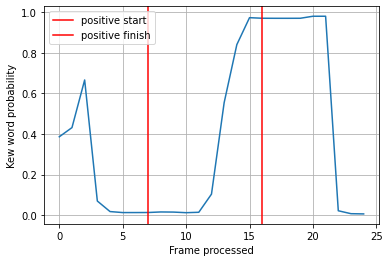

In [29]:
batch, labels = next(iter(train_loader))
batch = melspec_train(batch.to(CONFIG.device))

model_st.stream(False)
positive_idx = (labels == 1).nonzero()[0].item()
negative_idx1 = (labels == 0).nonzero()[0].item()
negative_idx2 = (labels == 0).nonzero()[1].item()

positive_sample = batch[positive_idx].unsqueeze(dim=0)
negative_sample1 = batch[negative_idx1].unsqueeze(dim=0)
negative_sample2 = batch[negative_idx2].unsqueeze(dim=0)

test_sample = torch.cat((negative_sample1, positive_sample, negative_sample2), dim=-1)

probs = []

model_st.clear_buffers()
model_st.stream(True)

# initial computation
with torch.no_grad():
    frame = test_sample[:, :, :frame_window_size]
    preds = torch.softmax(model_st(frame, is_initial=True), dim=-1)[:, 1]
    probs.append(preds.squeeze().item())

positive_start = None
positive_finish = None

step_size = CONFIG.kernel_size[1] - CONFIG.stride[1]
for i, pos in enumerate(range(frame_window_size, test_sample.shape[-1], step_size)):
    frame = test_sample[:, :, pos:pos+step_size]
    preds = torch.softmax(model_st(frame), dim=-1)[:, 1]
    with torch.no_grad():
        probs.append(preds.squeeze().item())
    
    if positive_start is None and pos > negative_sample1.shape[-1]:
        positive_start = i
    if positive_finish is None and pos > negative_sample1.shape[-1] + positive_sample.shape[-1]:
        positive_finish = i

plt.plot(probs)
plt.axvline(x=positive_start, label="positive start", c="red")
plt.axvline(x=positive_finish, label="positive finish", c="red")
plt.ylabel('Kew word probability')
plt.xlabel('Frame processed')
plt.grid()
plt.legend()
plt.show()


# 3. Compression and speed up experiments

## 3.1 Distillation (x2)

In [30]:
class SimpleDistilledCRNN(nn.Module):
    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels // 2,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels // 2,
            hidden_size=config.hidden_size // 2,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size // 2)
        self.classifier = nn.Linear(config.hidden_size // 2, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output


In [93]:
def train_epoch_kd(model, teacher_model, opt,loader, log_melspec, device, alpha, T):
    model.train()
    teacher_model.eval()

    criterion = nn.KLDivLoss()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()
        logits = model(batch)
        probs = F.softmax(logits, dim=-1)

        with torch.no_grad():
            teacher_logits = teacher_model(batch)

        loss = criterion(
            F.log_softmax(logits / T, dim=-1),
            F.softmax(teacher_logits / T, dim=-1)
        ) * (alpha * T * T) + F.cross_entropy(logits, labels) * (1. - alpha)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        opt.step()
        
        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc


def make_model_distillation(model, teacher_model, model_path=None, lr=0.001, alpha=0.8, T=1., path=None):
    """
        Load model weights from disc if path is not None and model file exists.
        In other case train from scratch and save weights
    """
    if path is not None and path in os.listdir():
        model.load_state_dict(torch.load(path))
        print(f'LOADED MODEL: au_fa_fr = {validation(model, val_loader, melspec_val, CONFIG.device)}')
        return

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1, gamma=0.95)
    history = defaultdict(list)
    
    n = 0
    au_fa_fr = 10.
    while au_fa_fr > MAX_QUALITY:
        train_epoch_kd(
            model, teacher_model, opt, train_loader,
            melspec_train, CONFIG.device, alpha, T
        )

        au_fa_fr = validation(
            model, val_loader, melspec_val, CONFIG.device
        )
        
        scheduler.step()

        history['val_metric'].append(au_fa_fr)

        clear_output()
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.grid()
        plt.show()

        print(f'END OF EPOCH {n}: au_fa_fr = {au_fa_fr}')
        n += 1

    if path is not None:
        torch.save(model.state_dict(), path)


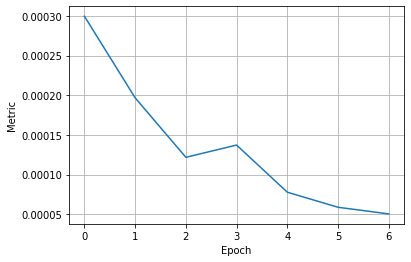

END OF EPOCH 6: au_fa_fr = 5.0300458561275e-05


In [35]:
simple_dist_model = SimpleDistilledCRNN(CONFIG).to(CONFIG.device)
make_model_distillation(simple_dist_model, base_model, path="simple_dist_model.pth")

In [36]:
get_model_target_stats(simple_dist_model, "simple_dist")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.SimpleDistilledCRNN'>. Treat it as zero Macs and zero Params.


{'simple_dist_model_size': 0.06893539428710938,
 'simple_dist_file_size': 0.07616138458251953,
 'simple_dist_macs': 35613696.0,
 'simple_dist_model_size_compression_rate': 3.898124066183388,
 'simple_dist_file_size_compression_rate': 3.620553211204468,
 'simple_dist_macs_speedup_rate': 3.3562207078984443}

## 3.2 Distillation (more)

In [37]:
class DistilledCRNN(nn.Module):
    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=4,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * 4,
            hidden_size=16,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(16)
        self.classifier = nn.Linear(16, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output


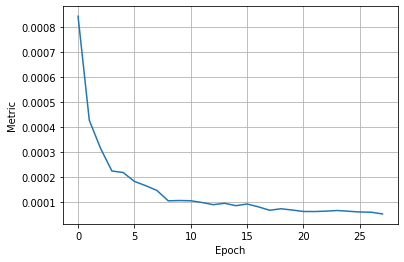

END OF EPOCH 27: au_fa_fr = 5.373776596800111e-05


In [38]:
dist_model = DistilledCRNN(CONFIG).to(CONFIG.device)
make_model_distillation(dist_model, base_model, T=10., path="dist_model.pth")

In [39]:
get_model_target_stats(dist_model, "dist")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.DistilledCRNN'>. Treat it as zero Macs and zero Params.


{'dist_model_size': 0.025478363037109375,
 'dist_file_size': 0.03270435333251953,
 'dist_macs': 19321856.0,
 'dist_model_size_compression_rate': 10.546938164395868,
 'dist_file_size_compression_rate': 8.431487475578106,
 'dist_macs_speedup_rate': 6.186125390852721}

## 3.3 Distillation (hard)

In [54]:
class DistilledHardCRNN(nn.Module):
    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=2,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * 2,
            hidden_size=12,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(12)
        self.classifier = nn.Linear(12, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output


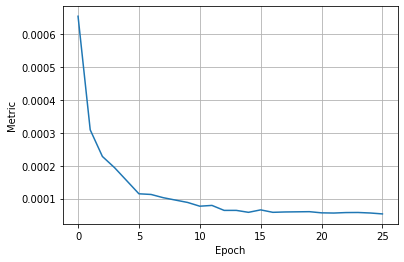

END OF EPOCH 25: au_fa_fr = 5.3427453493782784e-05


In [55]:
dist_hard_model = DistilledHardCRNN(CONFIG).to(CONFIG.device)
make_model_distillation(dist_hard_model, base_model, T=30., path="dist_hard_model.pth")

In [59]:
get_model_target_stats(dist_hard_model, prefix="dist_hard")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.DistilledHardCRNN'>. Treat it as zero Macs and zero Params.


{'dist_hard_model_size': 0.011951446533203125,
 'dist_hard_file_size': 0.022477149963378906,
 'dist_hard_macs': 9431040.0,
 'dist_hard_model_size_compression_rate': 22.484200446856047,
 'dist_hard_file_size_compression_rate': 12.26785183928041,
 'dist_hard_macs_speedup_rate': 12.673832790445168}

## 3.4 Baseline + dynamic quantization

In [43]:
quant_base_model = torch.quantization.quantize_dynamic(
    base_model, {nn.Linear, nn.GRU}, dtype=torch.qint8
)

au_fa_fr = validation(
    quant_base_model, val_loader,
    melspec_val, CONFIG.device
)

print("Model quality:", au_fa_fr)
torch.save(quant_base_model.state_dict(), "quant_base_model.pth")
get_model_target_stats(quant_base_model, "quant_base")

102it [00:02, 39.13it/s]


Model quality: 2.6203501428705486e-05
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <cla

{'quant_base_model_size': 0.003082275390625,
 'quant_base_file_size': 0.0834512710571289,
 'quant_base_macs': 20477952.0,
 'quant_base_model_size_compression_rate': 87.1819306930693,
 'quant_base_file_size_compression_rate': 3.304279755442546,
 'quant_base_macs_speedup_rate': 5.836883688368837}

## 3.5 Distillation (more) + dynamic quantization

In [44]:
quant_dist_model = torch.quantization.quantize_dynamic(
    dist_model, {nn.Linear, nn.GRU}, dtype=torch.qint8
)

au_fa_fr = validation(
    quant_dist_model, val_loader,
    melspec_val, CONFIG.device
)

print("Model quality:", au_fa_fr)
torch.save(quant_dist_model.state_dict(), "quant_dist_model.pth")
get_model_target_stats(quant_dist_model, "quant_dist")

102it [00:02, 40.98it/s]


Model quality: 5.169089714767637e-05
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <clas

{'quant_dist_model_size': 0.0015411376953125,
 'quant_dist_file_size': 0.019669532775878906,
 'quant_dist_macs': 10238976.0,
 'quant_dist_model_size_compression_rate': 174.3638613861386,
 'quant_dist_file_size_compression_rate': 14.018957575757575,
 'quant_dist_macs_speedup_rate': 11.673767376737674}

## 3.6 Distillation (hard) + dynamic quantization

In [58]:
quant_dist_hard_model = torch.quantization.quantize_dynamic(
    dist_hard_model, {nn.Linear, nn.GRU}, dtype=torch.qint8
)

au_fa_fr = validation(
    quant_dist_hard_model, val_loader,
    melspec_val, CONFIG.device
)

print("Model quality:", au_fa_fr)
torch.save(quant_dist_hard_model.state_dict(), "quant_dist_hard_model.pth")
get_model_target_stats(quant_dist_hard_model, "quant_dist_hard")

102it [00:02, 37.97it/s]


Model quality: 5.2377165119505366e-05
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <cla

{'quant_dist_hard_model_size': 0.00077056884765625,
 'quant_dist_hard_file_size': 0.015397071838378906,
 'quant_dist_hard_macs': 5119488.0,
 'quant_dist_hard_model_size_compression_rate': 348.7277227722772,
 'quant_dist_hard_file_size_compression_rate': 17.90901207804274,
 'quant_dist_hard_macs_speedup_rate': 23.347534753475347}

## 3.7 Some plots

In [64]:
models_list = [
    ("base", base_model),
    ("simple_dist", simple_dist_model),
    ("base_dist", dist_model),
    ("hard_dist", dist_hard_model),
    ("quant_base", quant_base_model),
    ("quant_base_dist", quant_dist_model),
    ("quant_hard_dist", quant_dist_hard_model)
]

results_dict = {}
for name, model in models_list:
    quality = validation(model, val_loader, melspec_val, CONFIG.device)
    metrics = get_model_target_stats(model, "", is_initial=True)
    size, macs = metrics["_file_size"], metrics["_macs"]
    if name.startswith("quant"):
        macs = results_dict[name[6:]][2]
    results_dict[name] = (quality, size, macs)

results_dict

102it [00:03, 29.36it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


102it [00:02, 35.31it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.SimpleDistilledCRNN'>. Treat it as zero Macs and zero Params.


102it [00:09, 11.00it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.DistilledCRNN'>. Treat it as zero Macs and zero Params.


102it [00:06, 15.18it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.DistilledHardCRNN'>. Treat it as zero Macs and zero Params.


102it [00:07, 13.02it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>

102it [00:07, 13.87it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>

102it [00:06, 15.18it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>

{'base': (2.5236758720563763e-05, 0.2791910171508789, 119527424.0),
 'simple_dist': (5.0300458561275e-05, 0.0796060562133789, 35613696.0),
 'base_dist': (5.373776596800111e-05, 0.036149024963378906, 19321856.0),
 'hard_dist': (5.3427453493782784e-05, 0.022477149963378906, 9431040.0),
 'quant_base': (2.6203501428705486e-05, 0.08713436126708984, 119527424.0),
 'quant_base_dist': (5.169089714767637e-05, 0.023352622985839844, 19321856.0),
 'quant_hard_dist': (5.2377165119505366e-05, 0.018958091735839844, 9431040.0)}

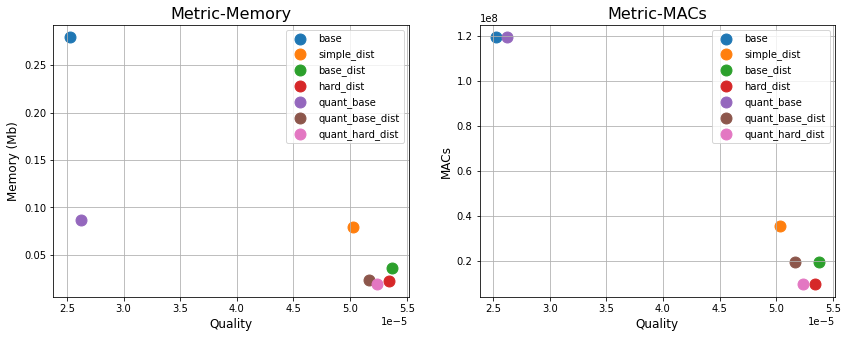

In [91]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
axs[0].set_title('Metric-Memory', fontsize=16)
axs[1].set_title('Metric-MACs', fontsize=16)

for name, values in results_dict.items():
    axs[0].scatter([values[0]], [values[1]], s=120, label=name)
axs[0].set_xlabel("Quality", fontsize=12)
axs[0].set_ylabel("Memory (Mb)", fontsize=12)
axs[0].legend()
axs[0].grid()

for name, values in results_dict.items():
    axs[1].scatter([values[0]], [values[2]], s=120, label=name)
axs[1].set_xlabel("Quality", fontsize=12)
axs[1].set_ylabel("MACs", fontsize=12)
axs[1].legend()
axs[1].grid()